### Locate nearest network node to each PAL field  

In [1]:
import osmnx as ox
import geopandas as gpd
import pyproj
import csv
import matplotlib.pyplot as plt
import os
import numpy as np


from shapely.geometry import Point
ox.settings.use_cache=True
ox.settings.log_console=True

In [2]:
# define paths
data_path = 'data'
output_path = 'output'

# set parent folder as working directory
os.chdir('..')
os.getcwd()

'c:\\Users\\isaldiviagonzatti\\Downloads\\gitFiles\\MScThesisCode\\FLP'

In [3]:
pyproj.datadir.set_data_dir('C:\\Users\\isaldiviagonzatti\\anaconda3\\envs\\ox\\Library\\share\\proj')
pyproj.datadir.get_data_dir()

'C:\\Users\\isaldiviagonzatti\\anaconda3\\envs\\ox\\Library\\share\\proj'

### Demonstration
We want to find the nearest edge to the centroids of all polygons representing the PA fields in the north-east region of Costa Rica.

First we demonstrate the process using a single point near Pital

In [4]:
%%time
# lat (y) lon(x) points

xlon = -84.278967
ylat = 10.476319
point = ylat, xlon # center of PA field near Pital

Gex = ox.graph_from_point(point, network_type='all_private', dist=1000)

# project the graph (and point) to a meter projection
Gpex = ox.project_graph(Gex)

point_geom_proj, crs = ox.projection.project_geometry(Point(reversed(point)), to_crs=Gpex.graph['crs'])
x, y = point_geom_proj.x, point_geom_proj.y


CPU times: total: 531 ms
Wall time: 1.18 s


In [5]:
%%time
# find nearest edge as (u, v, key) and distance to it
test, dist = ox.nearest_nodes(Gpex, Y=y, X=x, return_dist=True)

CPU times: total: 0 ns
Wall time: 7.21 ms


In [6]:
#convert u,v,key to list
unique_nodes = [test]

We also get the distance from the centroid to the edge (street) in meters. This will be used to penalize for transportation within the field

In [7]:
print(round(dist,2), 'meters')

274.95 meters


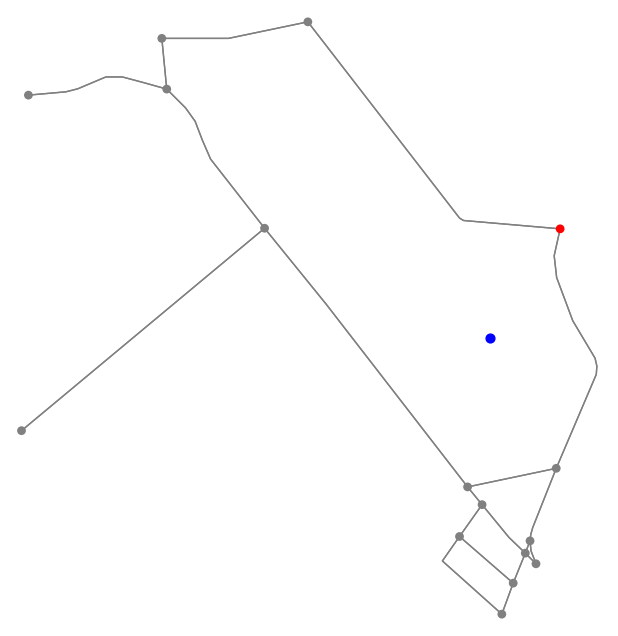

In [8]:
# In yellow is the centoid, in red we see the nearest steet to the centroid
ec = ['red' if e in unique_nodes else 'grey' for e in Gex.nodes]
#fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=1, node_size=0, show=False)
fig, ax = ox.plot_graph(Gex, node_color=ec, edge_linewidth=1, edge_color='grey', node_size=40, show=False, bgcolor='white')
ax = ax.scatter(xlon,ylat,c='blue', s=40, zorder=-1)

fig.savefig(os.path.join(output_path,'fieldNodeEx.svg'), bbox_inches='tight')

### Now we perform the same calculations with all pineapple fields centroids 

In [9]:
# read pineapple fields nodes data
pal = os.path.join(output_path, "palNorth.gpkg")
palPoint = gpd.read_file(pal)

In [10]:
%time
# load network of north of CR
northG = ox.graph.graph_from_bbox(11.2, 10.00, -83, -85.2, network_type = 'drive_service')
G_proj = ox.project_graph(northG)
Gs = ox.utils_graph.get_largest_component(northG, strongly=True)

CPU times: total: 0 ns
Wall time: 0 ns


In [11]:
# project graph and points to same CRS
#geom = gpd.points_from_xy(xlon, ylat)
gdf = gpd.GeoDataFrame(palPoint, crs='epsg:4326').to_crs(G_proj.graph['crs'])

In [12]:
%%time
# calculate nearest edge to each point
nePAL = ox.nearest_nodes(G_proj, X=gdf['geometry'].x, Y=gdf['geometry'].y,  return_dist=True)
#nePAL = ox.nearest_edges(G_proj, X=gdf['geometry'].x, Y=gdf['geometry'].y, interpolate=10, return_dist=True) #for edges

CPU times: total: 734 ms
Wall time: 761 ms


In [13]:
# store edge IDs and distances in different lists
nodesPAL = nePAL[0]
distPAL = nePAL[1]

Let's see how far is the farest centroid from its corresponding street:

In [14]:
print(max(distPAL), 'meters')

4215.325786369086 meters


In [22]:
#convert u,v,key to list
unique_nodes = set(nodesPAL)

In [23]:
print('We had', len(palPoint), 'polygons, and now we have', len(unique_nodes), 'nodes. Each node is connected to one or more polygons')

We had 2925 polygons, and now we have 1166 nodes. Each node is connected to one or more polygons


In [17]:
Gset = Gs.subgraph(unique_nodes)

In [18]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(northG)

In [19]:
#define lon, lat points
xlon=palPoint['geometry'].x
ylat=palPoint['geometry'].y

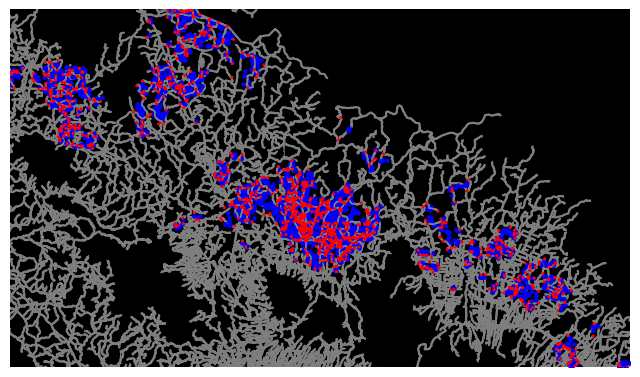

In [21]:
ec = ['r' if e in unique_nodes else 'grey' for e in Gset.nodes]
fig, ax = ox.plot_graph(Gset, node_color=ec, bgcolor='black', edge_color='grey', edge_linewidth=1, node_size=5, show=False, close= False, bbox=(11.04681261,10.09956058,-83.40407159,-85.07389766))
gdf_edges.plot(ax=ax, facecolor='black',  color="grey", zorder=-2)
#fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=1, node_size=0, show=False, bbox=(11.04681261,10.09956058,-83.40407159,-85.07389766))
ax = ax.scatter(xlon, ylat, c='blue', s=5, zorder=-1)

fig.savefig(os.path.join(output_path,'allNodesNet.pdf'), bbox_inches='tight')

Let's look at the area from the demonstration

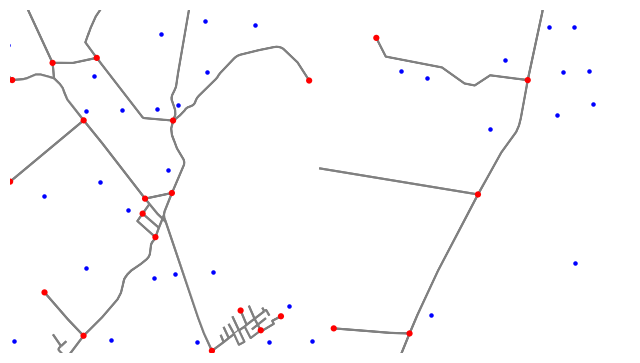

In [21]:
ec = ['r' if e in unique_nodes else 'grey' for e in Gset.nodes]
fig, ax = ox.plot_graph(Gset, node_color=ec, edge_linewidth=1, edge_color='grey', bgcolor='white', node_size=20, show=False, bbox=(10.4854,10.4637,-84.2482,-84.2881))
#fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=1, node_size=0, show=False, bbox=(10.4854,10.4637,-84.2482,-84.2881))
gdf_edges.plot(ax=ax, facecolor='white',  color="grey", zorder=-2)
ax = ax.scatter(xlon, ylat, c='blue', s=5, zorder=1)

fig.savefig(os.path.join(output_path,'allZoomNode.pdf'), bbox_inches='tight')

#### We save the tuple with osmid and distances to a csv

In [22]:
with open(os.path.join(output_path, "nearestNodePAL.csv"), 'w') as f:
    writer = csv.writer(f , lineterminator='\n')
    for tup in nePAL:
        writer.writerow(tup)